<a href="https://colab.research.google.com/github/akshay8867/Refined_Code/blob/master/Abstracts_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **In this worksheet, I utilised topic modelling to extract the topics from the abstracts of the articles. I also conducted journal wise topic modelling as well.**

In [1]:
!pip install --upgrade gensim
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

!pip install pyLDAvis
!pip install nltk
!pip install seaborn 
import seaborn as sns
import gensim
from collections import defaultdict
gensim.__version__

     |████████████████████████████████| 24.2MB 172kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
--2021-03-23 16:37:33--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.0MB/s    in 1.3s    

2021-03-23 16:37:34 (12.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classi

'3.8.3'

In [2]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)     

/content/drive
Mounted at /content/drive


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,TfidfModel
from gensim.corpora import Dictionary
import seaborn as sns
import gensim
from collections import defaultdict

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import time
import shutil
import pickle
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import nltk
nltk.download('stopwords')

from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def pick_choice():
  path=r'/content/drive/MyDrive/Selected_Journals'
  # for root, directories, files in os.walk(path, topdown=False):
  #   for i in range(len(files)):
      
  #     if '.csv' in files[i]:
  #         print(files[i])

  no_of_docs=0
  columns = ["Authors","Author(s) ID","Title","Year","Source title","DOI","Cited by","Abstract","References","Language of Original Document","Document Type","EID","Index Keywords"]
  df_=pd.DataFrame(columns=columns)
  df_.head()
  for root, directories, files in os.walk(path, topdown=False):
    for i in files:
      if '.csv' in i:
        # print(os.path.join(path,files[i]))
        df2=pd.read_csv(os.path.join(root,i),usecols=columns)
        no_of_docs+=df2.shape[0]
        
        df2 =df2.reset_index(drop=True)
        # print(df2.shape)
        df_=pd.concat([df_,df2], axis=0)

        
  # print(no_of_docs)
  # print(df_.shape[0])
  df_.dropna(subset=['DOI'],inplace=True)
  df_ = df_.drop_duplicates(subset='Title', keep='first')
  df_=df_[df_['Language of Original Document']=='English']
  df_.fillna({"Document Type":"Not available","References":"Not available","Cited by":-1,"Index Keywords":"Not available"},inplace=True)
  return df_


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


def setup_bigrams(data_words):
    print("setup_bigrams started")
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10)  # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=10)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return bigram_mod, trigram_mod

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    print("make_bigrams started")
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts, bigram_mod, trigram_mod):
    print("make_trigrams started")
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatization(texts, allowed_postags=['NOUN','VERB']):
    nlp = spacy.load('en', disable=['parser', 'ner'])
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def calculate_frequency(id2word):
  ## how many times this token is present.
  top_occuring_words={id2word[k]:v for k,v in dict(sorted(id2word.cfs.items(),key=lambda x:x[1],reverse=True)).items()}
  ## top occuring words represented in indexes
  top_occuring_indexes=dict(sorted(id2word.cfs.items(),key=lambda x:x[1],reverse=True))
  ## how many documents contain this token.
  top_occuring_docs= {id2word[k]:v for k,v in dict(sorted(id2word.dfs.items(),key=lambda x:x[1],reverse=True)).items()}
  return top_occuring_words,top_occuring_indexes,top_occuring_docs


import concurrent.futures
def tf_idf_filteration1(link):
    # print("Link[2]:{}".format(link[2]))
    # (k,doc,low_value,corpus,id2word,tfidf)
    # if link[0]==0:
    #   print("Checking the reference of tfidf")
    #   print(tfidf[bow])
    # tfidf1=link[5]
    # id2word1=link[4]
    # corpus1=link[3]
    words_omitted = []
    finally_omitted_words = []
    word_list = defaultdict(int)


    bow = link[1]
    if link[0]==0:
      print("Checking the reference of tfidf in tfidf filteration")
      print(tfidf[bow])
    
    # print("BOW")
    # print(bow)
    # print(len(bow))
    # print("Original length:{}".format(str(len(bow))))
    low_value_words = []  # reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow] if value>link[2]]
    # print("Tf-idf")
    # print(tfidf_ids )
    # print("tfidf len:{}".format(str(len(tfidf_ids))))
    new_bow = [b for b in bow if b[0] in tfidf_ids ]
    # print(len(new_bow))
    # print("New length:{}".format(str(len(new_bow))))

    return new_bow
    # print("corpus[link[0]]")
    # print(corpus[link[0]])

    # print("New length reflected in corpus:{}".format(str(len(corpus[link[0]]))))
    

def cal_perc(a,perc):
  return np.percentile(a,perc)


def low_value_filter(perc,corpus,a):
  print("Length of a in low value filter func:{}".format(str(len(a))))
  
  low_value=cal_perc(a,perc)
  print("Low value is {}".format(low_value))
  print("Checking the reference of tfidf in low value filter")
  print(tfidf[corpus[0]])
  corpus=[(k,doc,low_value) for k,doc in enumerate(corpus)]
  print(corpus[0])
  i=0
  
  corpus1=[]
  while i < len(corpus):
      # print(i)
      if i +100< len(corpus):
          # print("hello")
          with concurrent.futures.ThreadPoolExecutor(100) as executor:
              results = executor.map(tf_idf_filteration1, corpus[i:i + 100])
          for x in results:
            corpus1.append(x)
          
          i=i+100
      else:
        # print("Entered else block")
        with concurrent.futures.ThreadPoolExecutor(100) as executor:
              results = executor.map(tf_idf_filteration1, corpus[i:])
        for x in results:
            corpus1.append(x)
        i=i+100
  print("*88888888")
  print(corpus1[:1])
  return corpus1


In [ ]:
import time
import shutil
import pickle

def topic_model(num_topics,corpus,id2word,lemma_text,perc,mallet_path,a,journal_name,tfidf):
  try:
    print("hello")
    print("Length of a in topic model function:{}".format(str(len(a))))
  
    t1=time.perf_counter()
    # print("Original corpus")
    # print(corpus)
    print("Original Length:{}".format(str(len(corpus[1]))))

    corpus=low_value_filter(perc,corpus,a)
    # print("New corpus")
    # print(corpus)
    print("New Length:{}".format(str(len(corpus[1]))))
    print("Corpus Updated")
    model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                  corpus=corpus, 
                                                  num_topics=num_topics, 
                                                  id2word=id2word,
                                                  random_seed=10,
                                                  optimize_interval=100,
                                                  iterations=1000)
    

    print("Model has been created")
    parent_dir=r'/content/drive/MyDrive/Abstract_topic1'
    child_dir="Perc{}Topics{}".format(str(perc),str(num_topics))
    if os.path.exists(os.path.join(parent_dir,journal_name,child_dir)):
      shutil.rmtree(os.path.join(parent_dir,journal_name,child_dir))
      print("Directory has been deleted")

    if not os.path.exists(os.path.join(parent_dir,journal_name,child_dir)):
        os.makedirs(os.path.join(parent_dir,journal_name,child_dir))
        print("Directory has been created")

    final_path=os.path.join(parent_dir,journal_name,child_dir)
    with open(os.path.join(final_path,"{}.pkl".format(str(num_topics))),'wb') as f :
      pickle.dump(model,f)

    with open(model.ftopickeys(),'r') as f:
      with open(os.path.join(final_path,"{}topickeys.txt".format(str(num_topics))),'w') as m:
        m.write(f.read())
    cv_val=['c_npmi','c_v','c_uci','u_mass']
    # cv_val=['c_npmi','c_uci']
    coherence_values=[] 

    with open(os.path.join(final_path,"{}coherenceval.txt".format(str(num_topics))),'w') as m:
      for coherence in cv_val:
        print(coherence)
        coherencemodel = CoherenceModel(model=model, texts=lemma_text, dictionary=id2word, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())
        m.write("{}:{}\n".format(coherence,str(coherencemodel.get_coherence())))

    t2=time.perf_counter()
    print("Ended in {} minutes".format(str((t2-t1)/60)))
    return 1
  except Exception as e:
    print("Exception occured:{}".format(e))
    return 0

# **The combinations performed are**
- **topicno=[5,10,14,20,25,30]**
- **perc_values=[25,50,75,95]**



In [ ]:
def perform_different_combinations(corpus,id2word,lemma_text,a,journal_name,tfidf):
  perc_values=[25,50,75,95]
  topicno=[5,10,14,20,25,30]
  
  for perc in perc_values:
    print(perc)
    for num_topics in topicno:
      mallet_path = '/content/mallet-2.0.8/bin/mallet'
      corpus=[id2word.doc2bow(doc,allow_update=True) for doc in lemma_text ]
      print("Length of corpus in perform_different:{}".format(str(len(corpus[0]))))
      result_list.append(topic_model(num_topics,corpus,id2word,lemma_text,perc,mallet_path,a,journal_name,tfidf))
      print("{} completed".format(str(num_topics)))


In [ ]:
def preprocess_docs(data):
    data_words = list(sent_to_words(data))
    print(data_words[:1])
    data_words= remove_stopwords(data_words)
    bigram_mod, trigram_mod = setup_bigrams(data_words)
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)
    data_lemmatized = lemmatization(data_words_bigrams,allowed_postags=['NOUN', 'VERB'])
    return data_lemmatized


In [ ]:
selected_journals=['Canadian Water Resources Journal','Water Research', 'Integrated Environmental Assessment and Management', 'Journal of Water Resources Planning and Management', 'Journal of Hydrology', 'Journal of Environmental Management', 'Water Resources Research', 'Environmental Modelling and Software', 'Sustainable Water Resources Management', 'Water Resources Management', 'Water Environment Research', 'Environmental Impact Assessment Review', 'Annual Review of Environment and Resources', 'Advances in Water Resources']
print(len(selected_journals))
print(len(set(selected_journals)))

14
14


# **Code block to execute main part**

selected_journals=['Canadian Water Resources Journal','Water Research',
 'Integrated Environmental Assessment and Management',
 'Journal of Water Resources Planning and Management',
 'Journal of Hydrology',
 'Journal of Environmental Management',
 'Water Resources Research',
 'Environmental Modelling and Software',
 'Sustainable Water Resources Management',
 'Water Resources Management',
 'Water Environment Research',
 'Environmental Impact Assessment Review',
 'Annual Review of Environment and Resources',
 'Advances in Water Resources']


model_training_choices=['All_Docs',"Common_Docs","Journal_Wise"]

In [ ]:
import os

result_list=[]
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'

model_training_choices=["Journal_Wise"]

selected_journals=['Water Research','Canadian Water Resources Journal',
                   'Sustainable Water Resources Management',
                   'Integrated Environmental Assessment and Management',
 'Journal of Water Resources Planning and Management',
 'Journal of Hydrology',
 'Journal of Environmental Management',
 'Water Resources Research',
 'Environmental Modelling and Software',
 'Sustainable Water Resources Management',
 'Water Resources Management',
 'Water Environment Research',
 'Environmental Impact Assessment Review',
 'Annual Review of Environment and Resources',
 'Advances in Water Resources']




for choice in model_training_choices:
  
  if choice=='All_Docs':
    print("{} started".format(choice))
    df1=pick_choice()
    df1=df1[df1['Source title'].isin(selected_journals)]
    df1.reset_index(drop=True,inplace=True)
    data = df1.Abstract.values.tolist()
    print(data[0])
    data_lemmatized=preprocess_docs(data)
    id2word=Dictionary()
    corpus=[id2word.doc2bow(doc,allow_update=True) for doc in data_lemmatized]
    print(len(corpus))
    
    tfidf=TfidfModel(corpus,id2word,normalize=True)
    a=[]
    for doc in corpus:
      for id, value in tfidf[doc]:
        a.append(value)
    perform_different_combinations(corpus,id2word,data_lemmatized,a,choice,tfidf)
  
  elif choice=="Common_Docs":
    print("{} started".format(choice))
    df1=pick_choice()
    common_df=pd.read_pickle(r'/content/drive/MyDrive/pdf_links_df.pkl')
    common_df=common_df.merge(df1,how="inner",left_on="doi",right_on="DOI")
    common_df=common_df[df1.columns]
    common_df.reset_index(drop=True,inplace=True)
    data = common_df.Abstract.values.tolist()
    print(data[0])
    data_lemmatized=preprocess_docs(data)
    id2word=Dictionary()
    corpus=[id2word.doc2bow(doc,allow_update=True) for doc in data_lemmatized ]
    print("From beginning the lenhth of corpus[0]:{}".format(len(corpus[0])))
    tfidf=TfidfModel(corpus,id2word,normalize=True)
    a=[]
    for doc in corpus:
      for id, value in tfidf[doc]:
        a.append(value)
    perform_different_combinations(corpus,id2word,data_lemmatized,a,choice,tfidf)
  
  else:
    print("{} started".format(choice))
    df1=pick_choice()
    df1=df1[df1['Source title'].isin(selected_journals)]
    df1.reset_index(drop=True,inplace=True)
    for journal_name in selected_journals[:1]:
      print("*****************************")
      print(journal_name)
      df_sample=df1[df1['Source title']==journal_name]
      df_sample.reset_index(drop=True,inplace=True)
      data = df_sample.Abstract.values.tolist()
      data_lemmatized=preprocess_docs(data[:50])
      id2word=Dictionary()
      corpus=[id2word.doc2bow(doc,allow_update=True) for doc in data_lemmatized  ]
      print("From beginning the lenhth of corpus[0]:{}".format(len(corpus[0])))
      tfidf=TfidfModel(corpus,id2word,normalize=True)
      a=[]
      for doc in corpus:
        for id, value in tfidf[doc]:
          a.append(value)
      perform_different_combinations(corpus,id2word,data_lemmatized,a,journal_name,tfidf)
    


Journal_Wise started


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


*****************************
Water Research
[['sediment', 'microbial', 'communities', 'are', 'an', 'important', 'sink', 'for', 'both', 'organic', 'and', 'inorganic', 'nitrogen', 'with', 'mpb', 'biomass', 'making', 'the', 'largest', 'contribution', 'to', 'short', 'term', 'assimilation', 'and', 'retention', 'coastal', 'waters', 'are', 'increasingly', 'subject', 'to', 'anthropogenic', 'nutrient', 'enrichment', 'but', 'the', 'effect', 'of', 'nutrient', 'enrichment', 'on', 'microbial', 'assimilation', 'processing', 'and', 'fate', 'of', 'mpb', 'derived', 'mpb', 'remains', 'poorly', 'characterised', 'in', 'this', 'study', 'an', 'mpb', 'dominated', 'microbial', 'community', 'was', 'labeled', 'in', 'situ', 'with', 'pulse', 'of', 'nh', 'laboratory', 'core', 'incubations', 'of', 'this', 'labeled', 'sediment', 'under', 'increasing', 'nutrient', 'concentrations', 'nh', 'and', 'po', 'ambient', 'ambient', 'ambient', 'and', 'ambient', 'were', 'used', 'to', 'investigate', 'changes', 'in', 'the', 'proc

# **Extracting the coherence files and model objects for further analysis**

In [ ]:
topic_path=r'/content/drive/MyDrive/Abstract_topic1'
dict_alldocs={}
# dict_commdocs={}
journal_docs={}

selected_journals=['Water Research','Canadian Water Resources Journal',
                   'Sustainable Water Resources Management',
                   'Integrated Environmental Assessment and Management',
 'Journal of Water Resources Planning and Management',
 'Journal of Hydrology',
 'Journal of Environmental Management',
 'Water Resources Research',
 'Environmental Modelling and Software',
 'Sustainable Water Resources Management',
 'Water Resources Management',
 'Water Environment Research',
 'Environmental Impact Assessment Review',
 'Annual Review of Environment and Resources',
 'Advances in Water Resources']



for root,parent_dir,files in os.walk(topic_path,topdown=True):
  for pdir in parent_dir:
    
    # if "Perc" in pdir :
    #   if 'All_Docs' in os.path.join(root,pdir).split("/"): 
    #     print(os.path.join(root,pdir).split("/")[-1])
    #     for root1,dir1,files1 in os.walk(os.path.join(root,pdir)):
    #       file_components=[]
    #       for file in files1:
    #         print(os.path.join(root1,file))
    #         file_components.append(os.path.join(root1,file))
    #       dict_alldocs[os.path.join(root,pdir).split("/")[-1]]=file_components
      
      # if 'Common_Docs' in os.path.join(root,pdir).split("/"):
      #   print(os.path.join(root,pdir).split("/")[-1])
      #   for root1,dir1,files1 in os.walk(os.path.join(root,pdir)):
      #     file_components=[]
      #     for file in files1:
      #       print(os.path.join(root1,file))
      #       file_components.append(os.path.join(root1,file))
      #     # dict_commdocs[os.path.join(root,pdir).split("/")[-1]]=file_components
      
      if os.path.join(root,pdir).split("/")[-2] in selected_journals:
        journal_name=os.path.join(root,pdir).split("/")[-2]
        print(os.path.join(root,pdir).split("/")[-1])
        
        for root1,dir1,files1 in os.walk(os.path.join(root,pdir)):
          file_components=[]
          for file in files1:
            print(os.path.join(root1,file))
            file_components.append(os.path.join(root1,file))
          journal_docs[journal_name+"_"+os.path.join(root,pdir).split("/")[-1]]=file_components
      
      
      

      
  
  # for dir in dirs:
  #   file_components=[]
  #   if "Perc" in dir:
  #     for root1,dir1,files1 in os.walk(os.path.join(root,dir)):
  #       print(root1.split("/")[-1])
  #       for file in files1:
  #         print(os.path.join(root1,file))
  #         file_components.append(os.path.join(root1,file))
  #     dir_components[root1.split("/")[-1]]=file_components

        # print()

Perc25Topics5
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics5/5.pkl
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics5/5topickeys.txt
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics5/5coherenceval.txt
Perc25Topics10
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics10/10.pkl
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics10/10topickeys.txt
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics10/10coherenceval.txt
Perc25Topics14
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics14/14.pkl
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics14/14topickeys.txt
/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics14/14coherenceval.txt
Perc25Topics20
/content/drive/MyDrive/Abstract_topic1

In [ ]:
import matplotlib.pyplot as plt


def plot(coherence_df,coherence_measure):
  test_df=coherence_df[coherence_df['Coherence Type']==coherence_measure].reset_index(drop=True)
  test_df.reset_index(drop=False,inplace=True)
  fig, ax = plt.subplots()
  test_df.plot(x='index',y='Coherence Value',ax=ax)
  ax.legend([coherence_measure]);
  test_df_max=test_df[test_df['Coherence Value']==test_df['Coherence Value'].max()]
  return test_df,test_df_max


In [ ]:
def prepare_coherence_df(journal_name,journal_docs):
  coherence_df=pd.DataFrame(columns=['Combination','Coherence Type','Coherence Value'])
  
  for k,dct in journal_docs.items():
    # print(k)
    # print(dct)
    # print(k.split("_"))
    try:
      if journal_name ==k.split("_")[0]:
      
        with open(dct[-1],'r') as f:
            for line in f.readlines():
              # print(line.split(":")[0])
              # print(line.split(":")[1][:-1])
              df_=pd.DataFrame([{'Combination':k.split("_")[-1],'Coherence Type':line.split(":")[0]
                                ,'Coherence Value':float(line.split(":")[1][:-1])}])
              # print(df_)
              coherence_df=pd.concat([coherence_df,df_])
              # print("Coherence df")
              # print(coherence_df)
        coherence_df.reset_index(drop=True,inplace=True)
      
    except Exception as e:
      print(e)
  
  print(coherence_df)
  return coherence_df
      


In [ ]:
def prepare_final_df(test_df_u_mass_max,test_df_c_uci_max,test_df_c_npmi_max,test_df_cv_max):
  final_test_df=pd.DataFrame(columns=['index','Combination','Coherence Type','Coherence Value'])
  final_test_df=pd.concat([final_test_df,
                         test_df_u_mass_max,
                         test_df_c_uci_max,
                         test_df_c_npmi_max,
                         test_df_cv_max])
  final_test_df.reset_index(drop=True,inplace=True)
  final_test_df.drop(columns=['index'],inplace=True)
  final_test_df
  return final_test_df


In [ ]:
coherence_df=pd.DataFrame(columns=['Combination','Coherence Type','Coherence Value'])

for k,v in dict_alldocs.items():
  print(k)
  with open(v[-1],'r') as f:
    for line in f.readlines():
      print(line.split(":")[0])
      print(line.split(":")[1][:-1])
      df_=pd.DataFrame([{'Combination':k,'Coherence Type':line.split(":")[0]
                         ,'Coherence Value':float(line.split(":")[1][:-1])}])
      coherence_df=pd.concat([coherence_df,df_])
coherence_df.reset_index(drop=True,inplace=True)
coherence_df      

Perc25Topics5
c_npmi
0.0453818825421161
c_v
0.529605892274996
c_uci
0.33842959039154574
u_mass
-2.240108522997251
Perc25Topics10
c_npmi
0.053307663267208615
c_v
0.5554934568782401
c_uci
0.41974179650888954
u_mass
-2.3513961387858027
Perc25Topics14
c_npmi
0.054378849730483285
c_v
0.5506441641478527
c_uci
0.44032647097852656
u_mass
-2.4806076612751613
Perc25Topics20
c_npmi
0.05515033363079476
c_v
0.5472857852717967
c_uci
0.4555000996606977
u_mass
-2.5630881860270884
Perc25Topics25
c_npmi
0.06314686568865795
c_v
0.5686056423624628
c_uci
0.5351861822175695
u_mass
-2.655536907122606
Perc25Topics30
c_npmi
0.06245151087236019
c_v
0.5641492263257958
c_uci
0.5407150623406536
u_mass
-2.6993499331908786
Perc50Topics5
c_npmi
0.04389987667149446
c_v
0.5156037766683766
c_uci
0.33165971897076313
u_mass
-2.2907562321791217
Perc50Topics10
c_npmi
0.050824866366584696
c_v
0.5401519065198354
c_uci
0.40563165401857476
u_mass
-2.495505604532729
Perc50Topics14
c_npmi
0.05371902818859281
c_v
0.542532250818971

,Combination,Coherence Type,Coherence Value
0,Perc25Topics5,c_npmi,0.045382
1,Perc25Topics5,c_v,0.529606
2,Perc25Topics5,c_uci,0.338430
3,Perc25Topics5,u_mass,-2.240109
4,Perc25Topics10,c_npmi,0.053308
...,...,...,...
91,Perc95Topics25,u_mass,-5.399373
92,Perc95Topics30,c_npmi,-0.112576
93,Perc95Topics30,c_v,0.234417
94,Perc95Topics30,c_uci,-2.849523


# **Plotting for C_V**

In [ ]:
test_df_cv.sort_values(by=['Coherence Value'],ascending=False)


,index,Combination,Coherence Type,Coherence Value
4,4,Perc25Topics25,c_v,0.568606


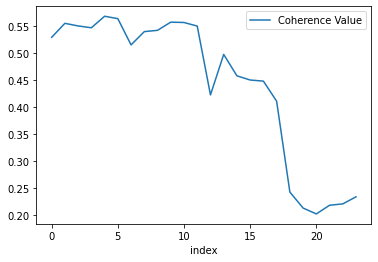

In [ ]:
test_df_cv=coherence_df[coherence_df['Coherence Type']=='c_v'].reset_index(drop=True)
test_df_cv.reset_index(drop=False,inplace=True)
test_df_cv.plot(x='index',y='Coherence Value')
test_df_cv[test_df_cv['Coherence Value']==test_df_cv['Coherence Value'].max()]

# **Plotting for C_NPMI**

,index,Combination,Coherence Type,Coherence Value
4,4,Perc25Topics25,c_npmi,0.063147


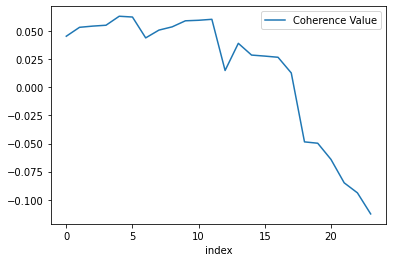

In [ ]:
test_df_c_npmi=coherence_df[coherence_df['Coherence Type']=='c_npmi'].reset_index(drop=True)
test_df_c_npmi.reset_index(drop=False,inplace=True)
test_df_c_npmi.plot(x='index',y='Coherence Value')
test_df_c_npmi[test_df_c_npmi['Coherence Value']==test_df_c_npmi['Coherence Value'].max()]

# **Plotting for C_UCI**

,index,Combination,Coherence Type,Coherence Value
5,5,Perc25Topics30,c_uci,0.540715


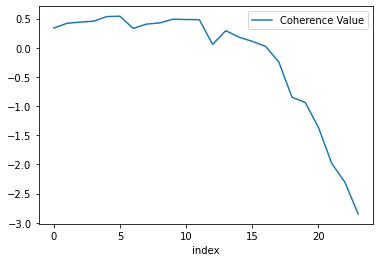

In [ ]:
test_df_c_uci=coherence_df[coherence_df['Coherence Type']=='c_uci'].reset_index(drop=True)
test_df_c_uci.reset_index(drop=False,inplace=True)
test_df_c_uci.plot(x='index',y='Coherence Value')
test_df_c_uci[test_df_c_uci['Coherence Value']==test_df_c_uci['Coherence Value'].max()]

# **Plotting for U_Mass**

,index,Combination,Coherence Type,Coherence Value
0,0,Perc25Topics5,u_mass,-2.240109


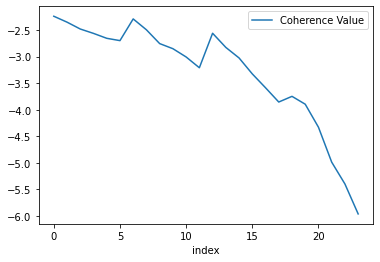

In [ ]:
test_df_u_mass=coherence_df[coherence_df['Coherence Type']=='u_mass'].reset_index(drop=True)
test_df_u_mass.reset_index(drop=False,inplace=True)
test_df_u_mass.plot(x='index',y='Coherence Value')
test_df_u_mass[test_df_u_mass['Coherence Value']==test_df_u_mass['Coherence Value'].max()]

In [ ]:
sddsfdsdsfsfdfdsfdfadadadasdasdasasdsdasdasddasdasdadas

In [ ]:
final_test_df=pd.DataFrame(columns=['index','Combination','Coherence Type','Coherence Value'])
final_test_df=pd.concat([final_test_df,
                         test_df_u_mass[test_df_u_mass['Coherence Value']==test_df_u_mass['Coherence Value'].max()],
                         test_df_c_uci[test_df_c_uci['Coherence Value']==test_df_c_uci['Coherence Value'].max()],
                         test_df_c_npmi[test_df_c_npmi['Coherence Value']==test_df_c_npmi['Coherence Value'].max()],
                         test_df_cv[test_df_cv['Coherence Value']==test_df_cv['Coherence Value'].max()]])
final_test_df.reset_index(drop=True,inplace=True)
final_test_df.drop(columns=['index'],inplace=True)
final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics5,u_mass,-2.240109
1,Perc25Topics30,c_uci,0.540715
2,Perc25Topics25,c_npmi,0.063147
3,Perc25Topics25,c_v,0.568606


In [ ]:
final_test_df['Combination'].value_counts()

Perc25Topics25    2
Perc25Topics30    1
Perc25Topics5     1
Name: Combination, dtype: int64

# **Topics generated by Perc25Topics25**

In [ ]:
with open(dict_alldocs["Perc25Topics25"][1],'r') as f:
  for line in f.readlines():
    print(line)


0	0.44423	scale region pattern variability drought relationship influence factor index variable variation characteristic show find response correlation difference dynamic basin climate 

1	0.43178	condition time rate function show case derive coefficient equation response obtain determine range predict calculate ratio describe curve relationship give 

2	0.19952	surface temperature flux lake measurement evaporation snow measure heat profile sensor wind day moisture layer observation depth difference ground range 

3	0.16388	study site forest vegetation plant tree fire year carbon cover plot canopy ecosystem root transpiration stand grass specie type treatment 

4	0.14541	treatment removal wastewater sludge process plant reactor degradation bacteria day substrate remove efficiency treat compost addition effluent cod cell performance 

5	0.17874	area wetland landscape specie impact population habitat exposure ecosystem fish land restoration biodiversity road conservation damage community

# **Now analysing the topics of abstracts for the documents for which we got full text**

In [ ]:
coherence_df_common=pd.DataFrame(columns=['Combination','Coherence Type','Coherence Value'])

for k,v in dict_commdocs.items():
  print(k)
  with open(v[-1],'r') as f:
    for line in f.readlines():
      print(line.split(":")[0])
      print(line.split(":")[1][:-1])
      df_=pd.DataFrame([{'Combination':k,'Coherence Type':line.split(":")[0]
                         ,'Coherence Value':float(line.split(":")[1][:-1])}])
      coherence_df_common=pd.concat([coherence_df_common,df_])
coherence_df_common.reset_index(drop=True,inplace=True)
coherence_df_common      

In [ ]:
coherence_df_common.sort_values(by=['Coherence Value'],ascending=False)

,Combination,Coherence Type,Coherence Value
29,Perc50Topics10,c_v,0.579076
13,Perc25Topics20,c_v,0.562532
21,Perc25Topics30,c_v,0.561724
17,Perc25Topics25,c_v,0.554430
41,Perc50Topics25,c_v,0.551755
...,...,...,...
94,Perc95Topics30,c_uci,-4.567323
83,Perc95Topics14,u_mass,-4.846873
87,Perc95Topics20,u_mass,-6.022976
91,Perc95Topics25,u_mass,-6.707624


In [ ]:
# with open(dict_commdocs['Perc75Topics30'][-2],'r') as f:
#   for line in f.readalines():
#     print(line.split(" "))

with open(dict_commdocs['Perc75Topics30'][0],'rb') as f:
  model75T30=pickle.load(f)

pprint(model75T30.print_topics(num_topics=30, num_words=20))

In [ ]:
Perc50Topics30=[]
dict_commdocs['Perc50Topics30']
# with open(dict_commdocs['Perc50Topics30'][-2],'r') as f:
#   for line in f.readlines():
#     print(line.split(" "))

with open(dict_commdocs['Perc50Topics30'][0],'rb') as f:
  model50T30=pickle.load(f)

pprint(model50T30.print_topics(num_topics=30, num_words=10))


# **Plotting for C_V for common docs**

,index,Combination,Coherence Type,Coherence Value
7,7,Perc50Topics10,c_v,0.579076


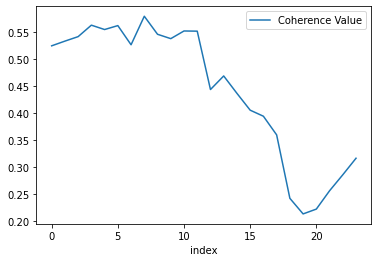

In [ ]:
test_df_cv_common=coherence_df_common[coherence_df_common['Coherence Type']=='c_v'].reset_index(drop=True)
test_df_cv_common.reset_index(drop=False,inplace=True)
test_df_cv_common.plot(x='index',y='Coherence Value')
test_df_cv_common[test_df_cv_common['Coherence Value']==test_df_cv_common['Coherence Value'].max()]

# **Plotting for C_NPMI**

,index,Combination,Coherence Type,Coherence Value
5,5,Perc25Topics30,c_npmi,0.06023


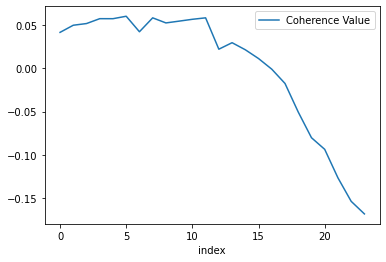

In [ ]:
test_df_c_npmi_common=coherence_df_common[coherence_df_common['Coherence Type']=='c_npmi'].reset_index(drop=True)
test_df_c_npmi_common.reset_index(drop=False,inplace=True)
test_df_c_npmi_common.plot(x='index',y='Coherence Value')
test_df_c_npmi_common[test_df_c_npmi_common['Coherence Value']==test_df_c_npmi_common['Coherence Value'].max()]

# **Plotting for C_UCI**

,index,Combination,Coherence Type,Coherence Value
5,5,Perc25Topics30,c_uci,0.45581


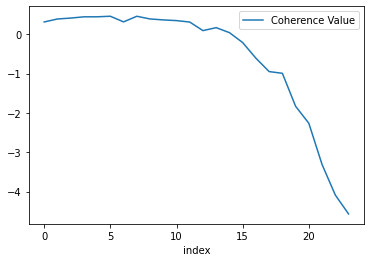

In [ ]:
test_df_c_uci_common=coherence_df_common[coherence_df_common['Coherence Type']=='c_uci'].reset_index(drop=True)
test_df_c_uci_common.reset_index(drop=False,inplace=True)
test_df_c_uci_common.plot(x='index',y='Coherence Value')
test_df_c_uci_common[test_df_c_uci_common['Coherence Value']==test_df_c_uci_common['Coherence Value'].max()]

# **Plotting for U_Mass**

,index,Combination,Coherence Type,Coherence Value
0,0,Perc25Topics5,u_mass,-2.33183


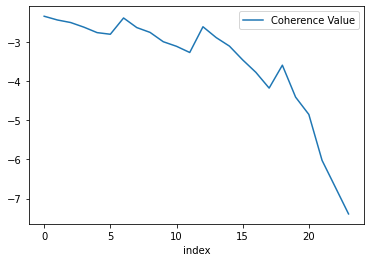

In [ ]:
test_df_u_mass_common=coherence_df_common[coherence_df_common['Coherence Type']=='u_mass'].reset_index(drop=True)
test_df_u_mass_common.reset_index(drop=False,inplace=True)
test_df_u_mass_common.plot(x='index',y='Coherence Value')
test_df_u_mass_common[test_df_u_mass_common['Coherence Value']==test_df_u_mass_common['Coherence Value'].max()]

In [ ]:
final_test_df_common=pd.DataFrame(columns=['index','Combination','Coherence Type','Coherence Value'])
final_test_df_common=pd.concat([final_test_df_common,
                         test_df_u_mass_common[test_df_u_mass_common['Coherence Value']==test_df_u_mass_common['Coherence Value'].max()],
                         test_df_c_uci_common[test_df_c_uci_common['Coherence Value']==test_df_c_uci_common['Coherence Value'].max()],
                         test_df_c_npmi_common[test_df_c_npmi_common['Coherence Value']==test_df_c_npmi_common['Coherence Value'].max()],
                         test_df_cv_common[test_df_cv_common['Coherence Value']==test_df_cv_common['Coherence Value'].max()]])
final_test_df_common.reset_index(drop=True,inplace=True)
final_test_df_common.drop(columns=['index'],inplace=True)
final_test_df_common

,Combination,Coherence Type,Coherence Value
0,Perc25Topics5,u_mass,-2.331830
1,Perc25Topics30,c_uci,0.455810
2,Perc25Topics30,c_npmi,0.060230
3,Perc50Topics10,c_v,0.579076


In [ ]:
final_test_df_common['Combination'].value_counts()

Perc25Topics30    2
Perc50Topics10    1
Perc25Topics5     1
Name: Combination, dtype: int64

# **Topics generated by Perc25Topics25**

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Common_Docs/Perc25Topics30/30topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.21114	surface flux temperature depth evaporation measurement profile layer energy heat moisture condition wind measure lake wave radiation calculate atmosphere gradient 

1	0.23703	model prediction simulation performance forecast calibration simulate predict develop input calibrate output forecasting improve modeling couple accuracy propose compare error 

2	0.24852	flow transport velocity solute tracer dispersion field plume particle mix heterogeneity experiment reaction medium spread diffusion region zone direction simulation 

3	0.21251	lake load treatment pollution quality reduction waste reduce nutrient impact wastewater standard emission pollutant facility include discharge contamination pond loading 

4	0.41632	structure control response dynamic behavior component state interaction framework hydrologic couple feature provide information mechanism represent link evolution integrate transition 

5	0.14733	effect condition exposure specie chemical fish toxicity risk population 

# **Now analysing the topics generated by individual journals**

# **Canadian Water Resources Journal**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.300063
1    Perc25Topics5            c_v         0.321268
2    Perc25Topics5          c_uci        -9.935043
3    Perc25Topics5         u_mass        -9.534667
4   Perc25Topics10         c_npmi        -0.213144
..             ...            ...              ...
91  Perc95Topics25         u_mass       -15.391045
92  Perc95Topics30         c_npmi        -0.387210
93  Perc95Topics30            c_v         0.372574
94  Perc95Topics30          c_uci       -13.106844
95  Perc95Topics30         u_mass       -15.096092

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.243419
1,Perc25Topics14,c_uci,-7.635282
2,Perc50Topics30,c_npmi,-0.157730
3,Perc25Topics30,c_v,0.625406


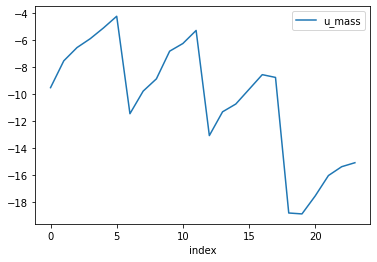

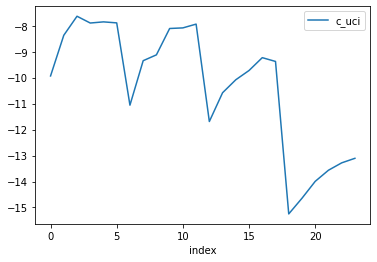

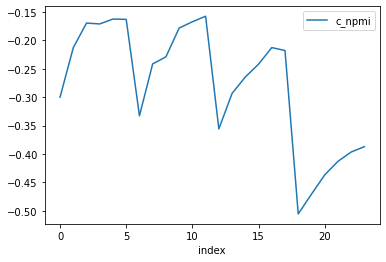

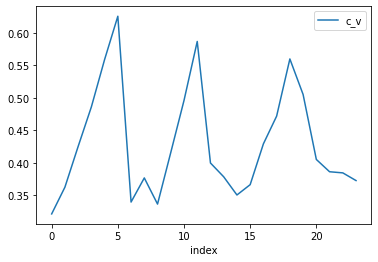

In [ ]:
coherence_df=prepare_coherence_df("Canadian Water Resources Journal",journal_docs)
cwrj_test_df_u_mass, cwrj_test_df_u_mass_max=plot(coherence_df,'u_mass')
cwrj_test_df_c_uci, cwrj_test_df_c_uci_max=plot(coherence_df,'c_uci')
cwrj_test_df_c_npmi, cwrj_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
cwrj_test_df_c_v, cwrj_test_df_c_v_max=plot(coherence_df,'c_v')
cwrj_final_test_df=prepare_final_df(cwrj_test_df_u_mass_max,cwrj_test_df_c_uci_max,cwrj_test_df_c_npmi_max,cwrj_test_df_c_v_max)
cwrj_final_test_df

In [ ]:
cwrj_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.243419
1,Perc25Topics14,c_uci,-7.635282
2,Perc50Topics30,c_npmi,-0.157730
3,Perc25Topics30,c_v,0.625406


In [ ]:
cwrj_final_test_df['Combination'].value_counts()

Perc25Topics30    2
Perc50Topics30    1
Perc25Topics14    1
Name: Combination, dtype: int64

# **Topics of Canadian Water Resources Journal Perc25Topics 30 (Only Abstracts)**

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Canadian Water Resources Journal/Perc25Topics30/30topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.02352	classification produce imagery extract extent result system develop weather surface radarsat occurrence mode map carry angle improve threshold hydrology term 

1	0.03967	lake model product subwatershe sensitivity routing route impact hydrologic include represent simulate scale streamflow range prediction ignore evaluate effort derive 

2	0.03995	review provide center radar weather river forecast research year context overview threshold establish emphasize induce trigger landscape emergency drought diversity 

3	0.01696	pond stormwater energy dissipation design offset depth discuss velocity tailwater jet height decay improve vector standard float designer consideration avenue 

4	0.01476	source water sst installation coliform represent pollutant point nutrient wwtp spring inflow flux contributor estimate precipitation stream discharge contribution surface 

5	0.04664	estimate flow site pool flood approach region similarity frequency measure group propose employ information qua

# **Water Resources Management**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.258998
1    Perc25Topics5            c_v         0.326945
2    Perc25Topics5          c_uci        -9.145727
3    Perc25Topics5         u_mass        -7.346287
4   Perc25Topics10         c_npmi        -0.261203
..             ...            ...              ...
91  Perc95Topics25         u_mass       -14.039201
92  Perc95Topics30         c_npmi        -0.444219
93  Perc95Topics30            c_v         0.427122
94  Perc95Topics30          c_uci       -13.746050
95  Perc95Topics30         u_mass       -12.686970

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-5.461152
1,Perc25Topics5,c_uci,-9.145727
2,Perc25Topics25,c_npmi,-0.221941
3,Perc25Topics30,c_v,0.576839


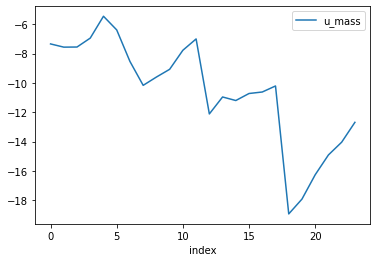

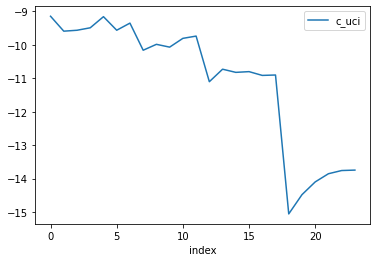

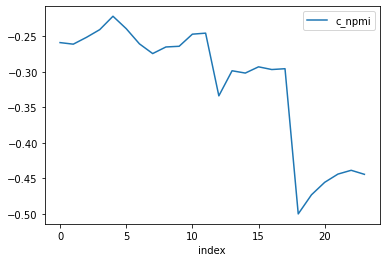

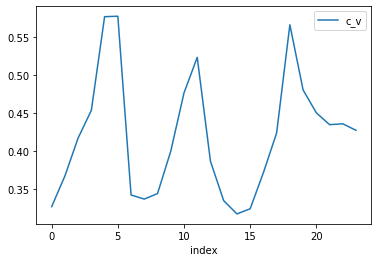

In [ ]:
coherence_df=prepare_coherence_df("Water Resources Management",journal_docs)
wrm_test_df_u_mass,wrm_test_df_u_mass_max=plot(coherence_df,'u_mass')
wrm_test_df_c_uci,wrm_test_df_c_uci_max=plot(coherence_df,'c_uci')
wrm_test_df_c_npmi, wrm_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
wrm_test_df_c_v,wrm_test_df_c_v_max=plot(coherence_df,'c_v')
wrm_final_test_df=prepare_final_df(wrm_test_df_u_mass_max,wrm_test_df_c_uci_max,wrm_test_df_c_npmi_max,wrm_test_df_c_v_max)
wrm_final_test_df

In [ ]:
wrm_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-5.461152
1,Perc25Topics5,c_uci,-9.145727
2,Perc25Topics25,c_npmi,-0.221941
3,Perc25Topics30,c_v,0.576839


In [ ]:
wrm_final_test_df['Combination'].value_counts()


Perc25Topics25    2
Perc25Topics30    1
Perc25Topics5     1
Name: Combination, dtype: int64

# **Topics of Water Resources Management Perc25Topics25**

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Water Resources Management/Perc25Topics25/25topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.10761	function demand management relate regulation author surface transportation recreation overview literature involve integrate extraction type foster duration production portion resiliency 

1	0.06252	gpr reservoir tane chl rely variable regression indicator determine concentration order hpsogwo nitrogen implementation training technique summarize relevance refer recognize 

2	0.09503	model flow simulate turbulence depth point river spillway safety measurement obtain level discharge anns experiment provide perform investigate interaction suitability 

3	0.04934	flow bed transport condition flux energy apply velocity streamwise sand equilibrium component characteristic establish surround summer key affect observation association 

4	0.23097	model watershed soil lash coefficient sustainability tool version validation calibrate behavior time simulation examine difference dynamic present evaluate set resource 

5	0.09366	service ecosystem evaluation process score transformation targ

# **Water Resources Research**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.252318
1    Perc25Topics5            c_v         0.323409
2    Perc25Topics5          c_uci        -8.796399
3    Perc25Topics5         u_mass        -8.648773
4   Perc25Topics10         c_npmi        -0.237594
..             ...            ...              ...
91  Perc95Topics25         u_mass       -16.077109
92  Perc95Topics30         c_npmi        -0.481638
93  Perc95Topics30            c_v         0.346567
94  Perc95Topics30          c_uci       -14.523498
95  Perc95Topics30         u_mass       -16.123187

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-5.540871
1,Perc25Topics25,c_uci,-7.994291
2,Perc50Topics30,c_npmi,-0.168106
3,Perc95Topics5,c_v,0.574789


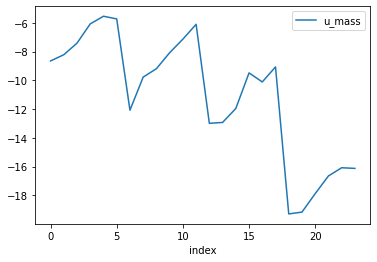

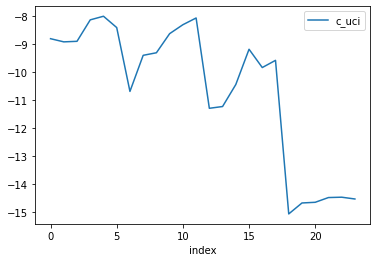

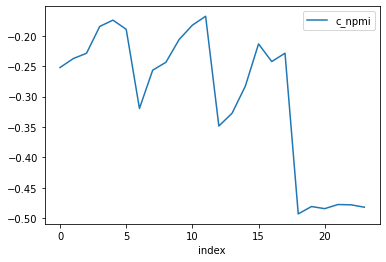

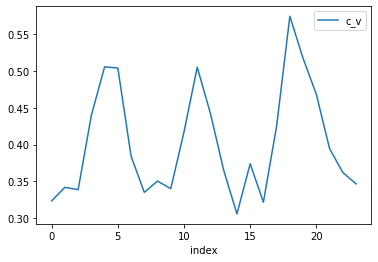

In [ ]:
coherence_df=prepare_coherence_df("Water Resources Research",journal_docs)
wrr_test_df_u_mass,wrr_test_df_u_mass_max=plot(coherence_df,'u_mass')
wrr_test_df_c_uci,wrr_test_df_c_uci_max=plot(coherence_df,'c_uci')
wrr_test_df_c_npmi, wrr_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
wrr_test_df_c_v,wrr_test_df_c_v_max=plot(coherence_df,'c_v')
wrr_final_test_df=prepare_final_df(wrr_test_df_u_mass_max,wrr_test_df_c_uci_max,wrr_test_df_c_npmi_max,wrr_test_df_c_v_max)
wrr_final_test_df

In [ ]:
wrr_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-5.540871
1,Perc25Topics25,c_uci,-7.994291
2,Perc50Topics30,c_npmi,-0.168106
3,Perc95Topics5,c_v,0.574789


## **Topics of Water Resources Research**

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Water Resources Research/Perc95Topics5/5topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.42734	forecast irrigation error precipitation uncertainty day concern inversion ttds area method force water_use forecasting relation retraction correspond research rainfall monitor 

1	0.25921	temperature reservoir river mode ebullition transport storage bathymetry turbination operation canyon bedrock wind bind speed injection adbar reconstruction radiation heat 

2	0.33559	flow evaporation fluid feed livestock crop equilibrium core reaction solute term mix salt accumulation input gradient permeability dissolution plume lense 

3	0.38654	event drift season catchment drainage aquifer bedload asm grace layer warm diffusivity disequilibrium bed solution flood reference swi invasion partitioning 

4	0.37826	groundwater site level ecosystem neutron state velocity number erosion haor bedrock plant wetland reav productivity land group age problem displacement 



# **Sustainable Water Resources Management**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.286754
1    Perc25Topics5            c_v         0.361468
2    Perc25Topics5          c_uci        -9.543778
3    Perc25Topics5         u_mass        -8.150641
4   Perc25Topics10         c_npmi        -0.271490
..             ...            ...              ...
91  Perc95Topics25         u_mass       -16.332103
92  Perc95Topics30         c_npmi        -0.466450
93  Perc95Topics30            c_v         0.317767
94  Perc95Topics30          c_uci       -14.364245
95  Perc95Topics30         u_mass       -15.878150

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-5.078226
1,Perc25Topics30,c_uci,-9.115445
2,Perc25Topics30,c_npmi,-0.215338
3,Perc95Topics5,c_v,0.617560


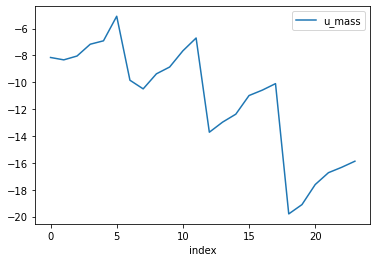

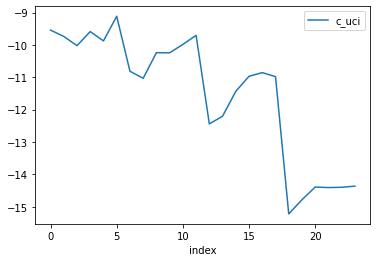

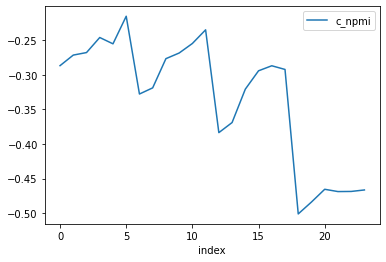

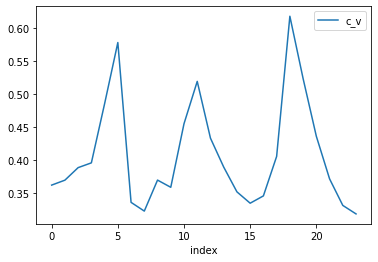

In [ ]:
coherence_df=prepare_coherence_df("Sustainable Water Resources Management",journal_docs)
swrm_test_df_u_mass, swrm_test_df_u_mass_max=plot(coherence_df,'u_mass')
swrm_test_df_c_uci, swrm_test_df_c_uci_max=plot(coherence_df,'c_uci')
swrm_test_df_c_npmi, swrm_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
swrm_test_df_c_v, swrm_test_df_c_v_max=plot(coherence_df,'c_v')
swrm_final_test_df=prepare_final_df(swrm_test_df_u_mass_max,swrm_test_df_c_uci_max,swrm_test_df_c_npmi_max,swrm_test_df_c_v_max)
swrm_final_test_df

In [ ]:
swrm_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-5.078226
1,Perc25Topics30,c_uci,-9.115445
2,Perc25Topics30,c_npmi,-0.215338
3,Perc95Topics5,c_v,0.617560


In [ ]:
swrm_final_test_df['Combination'].value_counts()

Perc25Topics30    3
Perc95Topics5     1
Name: Combination, dtype: int64

# **Topics of Sustainable Water Resources Management**

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Sustainable Water Resources Management/Perc95Topics5/5topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	1.06917	trend sediment point lake paper change domain yield supply policy forecasting snow end cluster calibrate bmp metal ecosystem village fluoride 

1	0.89648	model rainfall electricity basement country catchment body wetspass time_serie amount generation bangladesh lar gcms km wawqi pre presence success failure 

2	0.81588	structure fibre salinity groundwater recharge index modify factor stream power rift drainage institution erosion braid ganga floor waste relief behavior 

3	1.03538	river plan tank station harvesting technology soil strategy land_management evaluation classification prioritize facie discharge productivity protection chemistry toilet precipitation food 

4	0.94943	irrigation system method wetland fish specie rainwater_harvesting diversity sample sodium proximity lineament removal trawl quarter bird iwqi farmer morphometric stability 



# **Journal of Water Resources Planning and Management**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.252096
1    Perc25Topics5            c_v         0.340081
2    Perc25Topics5          c_uci        -8.571475
3    Perc25Topics5         u_mass        -6.059766
4   Perc25Topics10         c_npmi        -0.226128
..             ...            ...              ...
91  Perc95Topics25         u_mass       -10.984463
92  Perc95Topics30         c_npmi        -0.397118
93  Perc95Topics30            c_v         0.545179
94  Perc95Topics30          c_uci       -13.286260
95  Perc95Topics30         u_mass       -10.202842

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-5.410941
1,Perc25Topics10,c_uci,-8.560246
2,Perc50Topics30,c_npmi,-0.199795
3,Perc95Topics5,c_v,0.580053


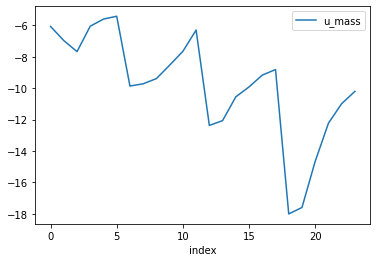

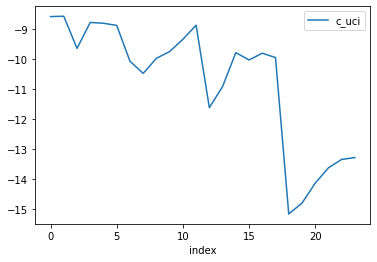

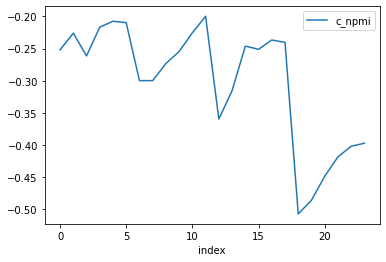

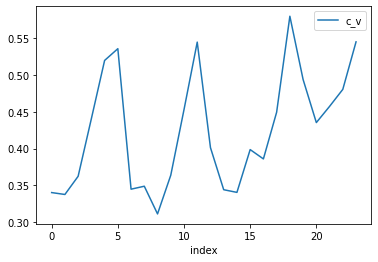

In [ ]:
coherence_df=prepare_coherence_df("Journal of Water Resources Planning and Management",journal_docs)
jwrp_test_df_u_mass, jwrp_test_df_u_mass_max=plot(coherence_df,'u_mass')
jwrp_test_df_c_uci, jwrp_test_df_c_uci_max=plot(coherence_df,'c_uci')
jwrp_test_df_c_npmi, jwrp_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
jwrp_test_df_c_v, jwrp_test_df_c_v_max=plot(coherence_df,'c_v')
jwrp_final_test_df=prepare_final_df(jwrp_test_df_u_mass_max,jwrp_test_df_c_uci_max,jwrp_test_df_c_npmi_max,jwrp_test_df_c_v_max)
jwrp_final_test_df

In [ ]:
jwrp_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-5.410941
1,Perc25Topics10,c_uci,-8.560246
2,Perc50Topics30,c_npmi,-0.199795
3,Perc95Topics5,c_v,0.580053


In [ ]:
jwrp_final_test_df['Combination'].value_counts()

Perc95Topics5     1
Perc50Topics30    1
Perc25Topics30    1
Perc25Topics10    1
Name: Combination, dtype: int64

## **Topics of Journal of Water Resources Planning and Management**

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Journal of Water Resources Planning and Management/Perc95Topics5/5topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	1.41527	user procedure change snowpack adaptation state power scenario decline project vulnerability rate regime hydropower drainage tribunal lstm_base rcp filter decomposition 

1	1.40605	risk sensor method reservoir service scheme process measure pipe land flood_regulation view design rule ecosystem expectation monitoring monitor cover forum 

2	1.45367	indicator resilience datum lead gerd pressure failure fill revenue canal demand index epanet problem transmission test filling trend burst allocation 

3	1.15398	forecast cluster everglade information salinity consumer lstm_base cerp restoration zone plant sensitivity power_generation predict parameter precondition algorithm tp_export season regime 

4	1.52829	pump crack performance aquifer dma salinization energy consumption activity emergency feed detection agent district robustness country development infrastructure leakage speed 



# **Water Environment Research**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.267845
1    Perc25Topics5            c_v         0.357376
2    Perc25Topics5          c_uci        -9.121112
3    Perc25Topics5         u_mass        -9.407812
4   Perc25Topics10         c_npmi        -0.205654
..             ...            ...              ...
91  Perc95Topics25         u_mass       -15.339180
92  Perc95Topics30         c_npmi        -0.384613
93  Perc95Topics30            c_v         0.387623
94  Perc95Topics30          c_uci       -13.065476
95  Perc95Topics30         u_mass       -14.919956

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.631881
1,Perc25Topics25,c_uci,-7.044762
2,Perc50Topics30,c_npmi,-0.113456
3,Perc25Topics30,c_v,0.643579


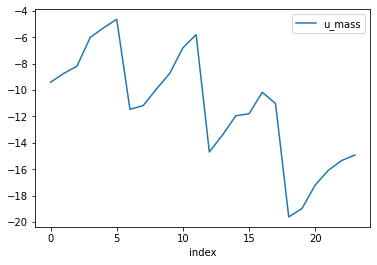

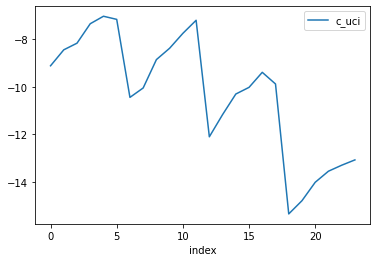

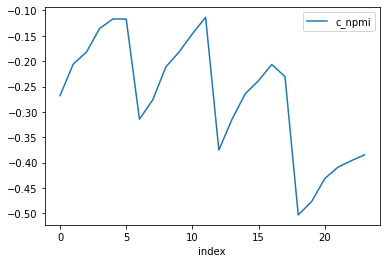

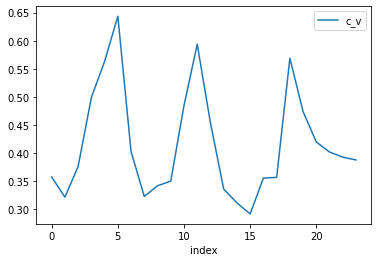

In [ ]:
coherence_df=prepare_coherence_df("Water Environment Research",journal_docs)
wer_test_df_u_mass, wer_test_df_u_mass_max=plot(coherence_df,'u_mass')
wer_test_df_c_uci, wer_test_df_c_uci_max=plot(coherence_df,'c_uci')
wer_test_df_c_npmi, wer_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
wer_test_df_c_v, wer_test_df_c_v_max=plot(coherence_df,'c_v')
wer_final_test_df=prepare_final_df(wer_test_df_u_mass_max,wer_test_df_c_uci_max,wer_test_df_c_npmi_max,wer_test_df_c_v_max)
wer_final_test_df

In [ ]:
wer_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.631881
1,Perc25Topics25,c_uci,-7.044762
2,Perc50Topics30,c_npmi,-0.113456
3,Perc25Topics30,c_v,0.643579


In [ ]:
wer_final_test_df['Combination'].value_counts()

Perc25Topics30    2
Perc25Topics25    1
Perc50Topics30    1
Name: Combination, dtype: int64

## **Topics of Water Environment Research**

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Water Environment Research/Perc25Topics30/30topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.00713	membrane rejection increase permeance lead water compare oxide nickel iron selectivity pore polysulfone leach achieve nanocomposite performance upto ultrafiltration scanning 

1	0.02579	degradation cap decolorization performance formation efficiency product enrich wavelength introduction disinfection capability achieve presence pichia improvement fold field intensity enhance 

2	0.00911	treatment kefir leachate landfill lactis grain yeast marxianu bioremediation bacteria approach removal kluyveromyce isolate microorganism issue performance rate strain size 

3	0.01663	algae coverage interest finding pollutant include substratum topic bacteria toxin physiology interaction grazer freshwater ecology cyanobacteria bloom bioassessment bacteriophage auto 

4	0.01793	sdbs sds increase concentration structure enzyme_activity denitrifier aerobic_denitrification community affect sodium nitrogen efficiency dodecyl activity variation surfactant sulfonate strengthen river 

5	0.03501	adso

# **Integrated Environmental Assessment and Management**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.260903
1    Perc25Topics5            c_v         0.386082
2    Perc25Topics5          c_uci        -9.448410
3    Perc25Topics5         u_mass        -7.903277
4   Perc25Topics10         c_npmi        -0.248470
..             ...            ...              ...
91  Perc95Topics25         u_mass       -11.706798
92  Perc95Topics30         c_npmi        -0.405252
93  Perc95Topics30            c_v         0.483254
94  Perc95Topics30          c_uci       -13.215453
95  Perc95Topics30         u_mass       -11.257278

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-3.021613
1,Perc25Topics25,c_uci,-7.636925
2,Perc25Topics30,c_npmi,-0.145857
3,Perc25Topics30,c_v,0.702837


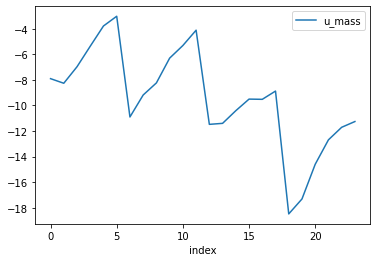

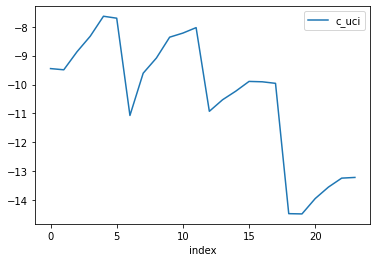

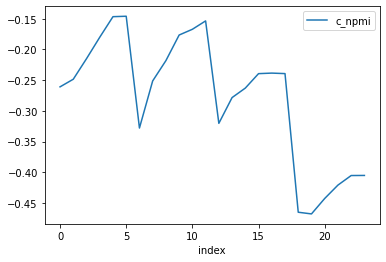

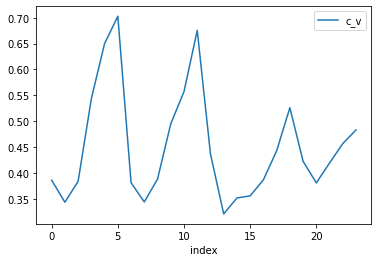

In [ ]:
coherence_df=prepare_coherence_df("Integrated Environmental Assessment and Management",journal_docs)
ieam_test_df_u_mass, ieam_test_df_u_mass_max=plot(coherence_df,'u_mass')
ieam_test_df_c_uci, ieam_test_df_c_uci_max=plot(coherence_df,'c_uci')
ieam_test_df_c_npmi, ieam_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
ieam_test_df_c_v, ieam_test_df_c_v_max=plot(coherence_df,'c_v')
ieam_final_test_df=prepare_final_df(ieam_test_df_u_mass_max,ieam_test_df_c_uci_max,ieam_test_df_c_npmi_max,ieam_test_df_c_v_max)
ieam_final_test_df

In [ ]:
ieam_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-3.021613
1,Perc25Topics25,c_uci,-7.636925
2,Perc25Topics30,c_npmi,-0.145857
3,Perc25Topics30,c_v,0.702837


In [ ]:
ieam_final_test_df['Combination'].value_counts()

Perc25Topics30    3
Perc25Topics25    1
Name: Combination, dtype: int64

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Integrated Environmental Assessment and Management/Perc25Topics30/30topickeys.txt') as f:
  for line in f.readlines():
    print(line)

0	0.05174	irrigation strategy farmer drainage crop price model management water resource irrigate result yield lead purpose reduction field fw decrease propose 

1	0.02527	ess cpzs method estimate component priority ecosystem model zonation vor sundarban step score researcher reference mangrove ecoregion demarcation block biodiversity 

2	0.01855	wetland pesticide concentration land season number guideline detect sample specie sugar find degradate cane type occur ship representation process transport 

3	0.04011	impact adoption electricity level material compare source saving panel manufacture grid technology respect phase generate correspond carbon assessment term river 

4	0.02247	evidence inference review make assessment weigh assemble combine practice domain analysis literature weight article publish characterize work government integrate unbiase 

5	0.05709	affect area plant sample soil control increase leave collect root element decumben content fe rupture tissue concentration fa

## **Environmental Impact Assessment Review**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.335908
1    Perc25Topics5            c_v         0.331295
2    Perc25Topics5          c_uci       -10.964341
3    Perc25Topics5         u_mass       -10.223103
4   Perc25Topics10         c_npmi        -0.262644
..             ...            ...              ...
91  Perc95Topics25         u_mass       -11.227841
92  Perc95Topics30         c_npmi        -0.450918
93  Perc95Topics30            c_v         0.535260
94  Perc95Topics30          c_uci       -14.070892
95  Perc95Topics30         u_mass       -10.510286

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.864439
1,Perc25Topics30,c_uci,-8.664858
2,Perc25Topics30,c_npmi,-0.191972
3,Perc25Topics30,c_v,0.613644


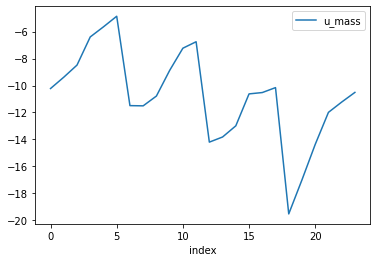

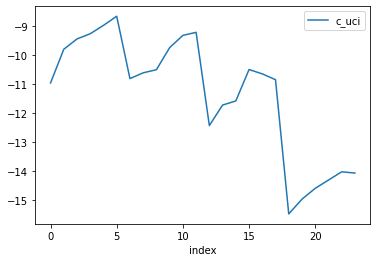

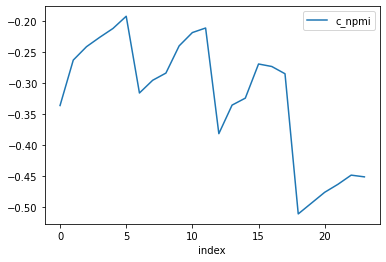

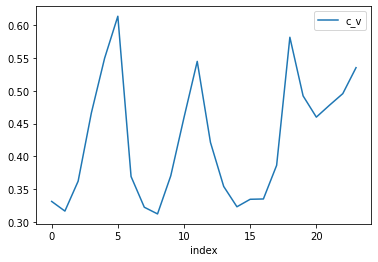

In [ ]:
coherence_df=prepare_coherence_df("Environmental Impact Assessment Review",journal_docs)
eiar_test_df_u_mass, eiar_test_df_u_mass_max=plot(coherence_df,'u_mass')
eiar_test_df_c_uci, eiar_test_df_c_uci_max=plot(coherence_df,'c_uci')
eiar_test_df_c_npmi, eiar_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
eiar_test_df_c_v, eiar_test_df_c_v_max=plot(coherence_df,'c_v')
eiar_final_test_df=prepare_final_df(eiar_test_df_u_mass_max,eiar_test_df_c_uci_max,eiar_test_df_c_npmi_max,eiar_test_df_c_v_max)
eiar_final_test_df

In [ ]:
eiar_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.864439
1,Perc25Topics30,c_uci,-8.664858
2,Perc25Topics30,c_npmi,-0.191972
3,Perc25Topics30,c_v,0.613644


In [ ]:
eiar_final_test_df['Combination'].value_counts()

Perc25Topics30    4
Name: Combination, dtype: int64

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Environmental Impact Assessment Review/Perc25Topics30/30topickeys.txt') as f:
  for line in f.readlines():
    print(line)

0	0.05396	eia quality report attribute logic criterion type toolbox score framework select plant hydropower performance importance change rule review organize input 

1	0.05769	effect pollutant article air pm governance polymer nanoparticle nanocomposite biosensor regard month control water improvement technique performance property trade pool 

2	0.08475	field author technology odour device compound vulnerability possibility assume bibliometric accept measurement decrease carry develop community evolution analyze trend represent 

3	0.08815	literature paper challenge process tool promote tea assessment procedure conduct involve conclude accord awareness lead purpose perspective design identify choice 

4	0.05965	project case base system expert approach strengthen combine make type toolset restrict face screening perform intelligence index decision deal appraisal 

5	0.03697	carbon embody product trading emission export division co_emission globalization effect manufacturing locate hem

## **Journal of Environmental Management**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.312605
1    Perc25Topics5            c_v         0.316913
2    Perc25Topics5          c_uci       -10.427457
3    Perc25Topics5         u_mass        -9.885833
4   Perc25Topics10         c_npmi        -0.265758
..             ...            ...              ...
91  Perc95Topics25         u_mass       -16.527699
92  Perc95Topics30         c_npmi        -0.462760
93  Perc95Topics30            c_v         0.291157
94  Perc95Topics30          c_uci       -14.061690
95  Perc95Topics30         u_mass       -15.940043

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.907251
1,Perc25Topics30,c_uci,-7.767264
2,Perc25Topics30,c_npmi,-0.153086
3,Perc95Topics5,c_v,0.582124


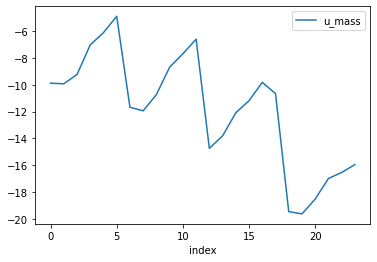

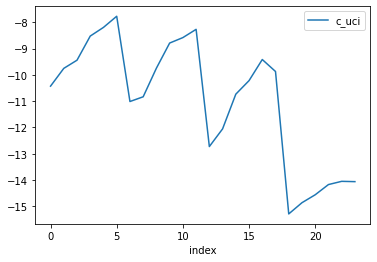

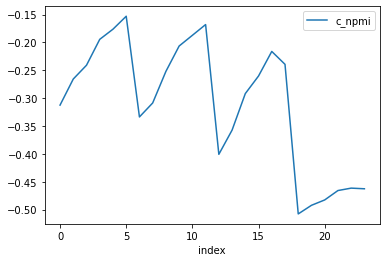

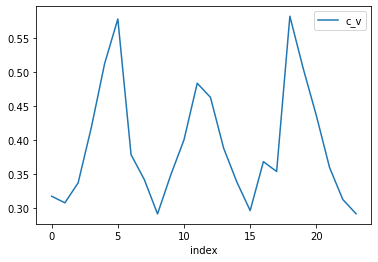

In [ ]:
coherence_df=prepare_coherence_df("Journal of Environmental Management",journal_docs)
jem_test_df_u_mass, jem_test_df_u_mass_max=plot(coherence_df,'u_mass')
jem_test_df_c_uci, jem_test_df_c_uci_max=plot(coherence_df,'c_uci')
jem_test_df_c_npmi, jem_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
jem_test_df_c_v, jem_test_df_c_v_max=plot(coherence_df,'c_v')
jem_final_test_df=prepare_final_df(jem_test_df_u_mass_max,jem_test_df_c_uci_max,jem_test_df_c_npmi_max,jem_test_df_c_v_max)
jem_final_test_df

In [ ]:
jem_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.907251
1,Perc25Topics30,c_uci,-7.767264
2,Perc25Topics30,c_npmi,-0.153086
3,Perc95Topics5,c_v,0.582124


In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Journal of Environmental Management/Perc95Topics5/5topickeys.txt') as f:
  for line in f.readlines():
    print(line)

0	0.26131	grass area cd norm policy recovery seed generation electricity straw irrigation field surface input maize reactor precipitation landowner invade monitor 

1	0.30584	water segment emission_dominating resilience city chlorine transfer gas antibiotic grade ion electrode layer insurer event dosage tipa pore hydration network 

2	0.29352	soil compost tem year removal temb immobilization require wastewater article immobilized_lc isotope reservoir neonicotinoid technosol reclamation enzyme lyr floodwater pollute 

3	0.32936	chocolate diffusion land ice scale cover management transportation recruitment behavior manufacture peb practice stability mat grassland extent seedle deer efficacy 

4	0.42377	pesticide metal region waste vulnerability export climate_change fertilizer leakage spring tourist element plastic farmer response adsorption purchase recycling pollution variability 



## **Water Research**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.303135
1    Perc25Topics5            c_v         0.324877
2    Perc25Topics5          c_uci       -10.166860
3    Perc25Topics5         u_mass        -9.069974
4   Perc25Topics10         c_npmi        -0.293091
..             ...            ...              ...
91  Perc95Topics25         u_mass       -15.263826
92  Perc95Topics30         c_npmi        -0.431465
93  Perc95Topics30            c_v         0.341312
94  Perc95Topics30          c_uci       -13.631253
95  Perc95Topics30         u_mass       -14.537160

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.774717
1,Perc25Topics30,c_uci,-8.103516
2,Perc25Topics30,c_npmi,-0.168447
3,Perc25Topics30,c_v,0.601772


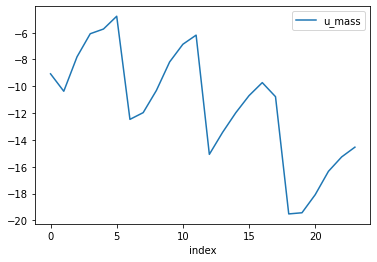

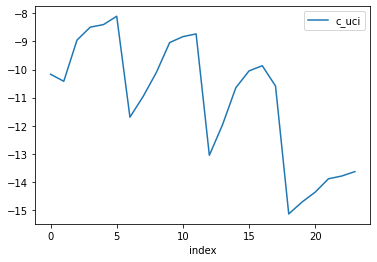

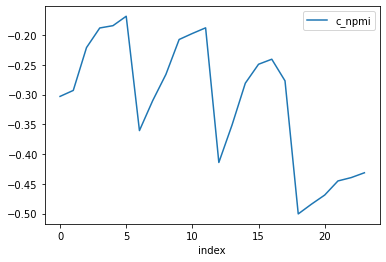

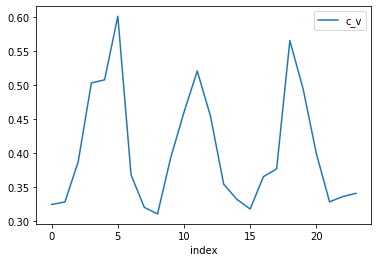

In [ ]:
coherence_df=prepare_coherence_df("Water Research",journal_docs)
wr_test_df_u_mass, wr_test_df_u_mass_max=plot(coherence_df,'u_mass')
wr_test_df_c_uci, wr_test_df_c_uci_max=plot(coherence_df,'c_uci')
wr_test_df_c_npmi, wr_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
wr_test_df_c_v, wr_test_df_c_v_max=plot(coherence_df,'c_v')
wr_final_test_df=prepare_final_df(wr_test_df_u_mass_max,wr_test_df_c_uci_max,wr_test_df_c_npmi_max,wr_test_df_c_v_max)
wr_final_test_df

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Water Research/Perc25Topics30/30topickeys.txt') as f:
  for line in f.readlines():
    print(line)

0	0.03062	membrane foul cake layer algae force mitigate bdd interaction form filtration reduce tricyclazole resistance repulsion prove pore organic filtrate dynamic 

1	0.06213	sludge treatment review biochar performance method electrode discuss cost propose waste passivation offer emerge knowledge generate dewatere operation reutilization gap 

2	0.02417	formation abatement edc oxidant clo chlorine impact dose disinfection pre observe development uv surrogate ring moiety cleavage benefit type suggest 

3	0.05101	sample fluorescence material fire burn compare decrease leach year rainstorm_event fuel coagulation process precursor change rainwater prescribe litter forest probe 

4	0.04864	performance upset model strategy simulation predict benchmarke meta_asm score storage evaluate improvement play polymer biomass urbanisation organise interpretation capital zone 

5	0.05306	water city indicator framework circularity resource assess manage enable exist develop action assessment practice 

## **Advances in Water Resources**


       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.243331
1    Perc25Topics5            c_v         0.378866
2    Perc25Topics5          c_uci        -8.367753
3    Perc25Topics5         u_mass        -7.432596
4   Perc25Topics10         c_npmi        -0.213888
..             ...            ...              ...
91  Perc95Topics25         u_mass       -11.921628
92  Perc95Topics30         c_npmi        -0.421146
93  Perc95Topics30            c_v         0.507437
94  Perc95Topics30          c_uci       -13.577234
95  Perc95Topics30         u_mass       -11.016493

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-4.569635
1,Perc25Topics25,c_uci,-7.907185
2,Perc25Topics25,c_npmi,-0.170171
3,Perc25Topics30,c_v,0.555756


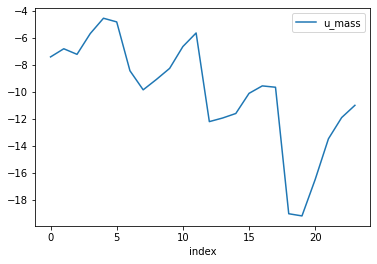

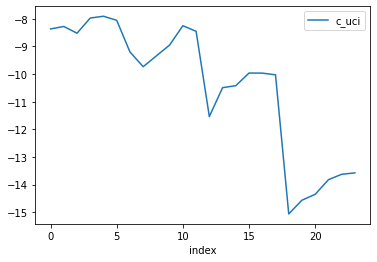

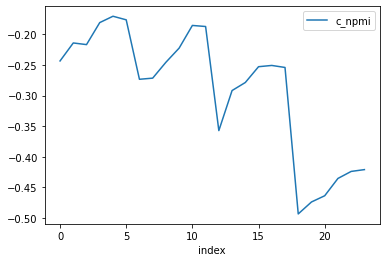

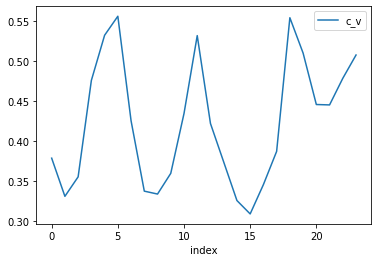

In [ ]:
coherence_df=prepare_coherence_df("Advances in Water Resources",journal_docs)
awr_test_df_u_mass, awr_test_df_u_mass_max=plot(coherence_df,'u_mass')
awr_test_df_c_uci, awr_test_df_c_uci_max=plot(coherence_df,'c_uci')
awr_test_df_c_npmi, awr_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
awr_test_df_c_v, awr_test_df_c_v_max=plot(coherence_df,'c_v')
awr_final_test_df=prepare_final_df(awr_test_df_u_mass_max,awr_test_df_c_uci_max,awr_test_df_c_npmi_max,awr_test_df_c_v_max)
awr_final_test_df

In [ ]:
awr_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-4.569635
1,Perc25Topics25,c_uci,-7.907185
2,Perc25Topics25,c_npmi,-0.170171
3,Perc25Topics30,c_v,0.555756


In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Advances in Water Resources/Perc25Topics25/25topickeys.txt') as f:
  for line in f.readlines():
    print(line)

0	0.01631	bed bore entrainment sediment load turbulence event swash suspend shock decay energy relate generate step dominate shoreline shear seaward mobilisation 

1	0.12685	propose system groundwater order time level dynamic field grid efficiency reduction term set pattern identify flux ratio difficulty detail component 

2	0.09137	improve resolution parameter accuracy distribution assimilation peak compare prediction moment shape study base uncertainty observation occurrence ɓrxii ɓriii tail reliability 

3	0.05511	interface trap phase fluid study force recirculation mechanism surface velocity invade ratio imbibition displacement capture analyze injection viscosity tension centroid 

4	0.11986	image method test solve performance material size develop simulation segmentation precipitation site nonstationarity resolution compare characteristic property memory index datum 

5	0.0318	algorithm decomposition risk problem system vector search portfolio reference framework tradeoff sort moe

## **Environmental modelling and software**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.354360
1    Perc25Topics5            c_v         0.371447
2    Perc25Topics5          c_uci       -11.192335
3    Perc25Topics5         u_mass       -10.782554
4   Perc25Topics10         c_npmi        -0.273904
..             ...            ...              ...
91  Perc95Topics25         u_mass       -15.179685
92  Perc95Topics30         c_npmi        -0.504860
93  Perc95Topics30            c_v         0.335772
94  Perc95Topics30          c_uci       -15.289352
95  Perc95Topics30         u_mass       -15.141653

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-7.369084
1,Perc25Topics20,c_uci,-9.119984
2,Perc25Topics20,c_npmi,-0.217902
3,Perc95Topics5,c_v,0.701744


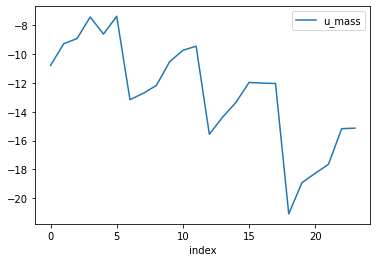

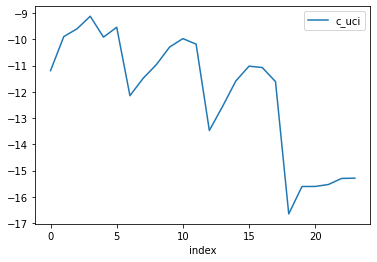

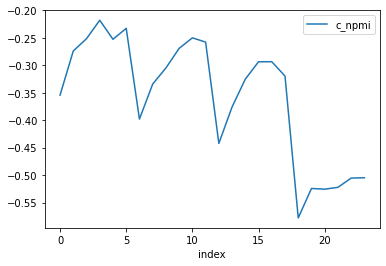

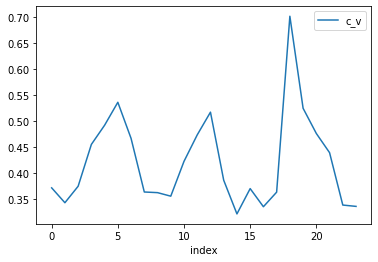

In [ ]:
coherence_df=prepare_coherence_df("Environmental Modelling and Software",journal_docs)
ems_test_df_u_mass, ems_test_df_u_mass_max=plot(coherence_df,'u_mass')
ems_test_df_c_uci, ems_test_df_c_uci_max=plot(coherence_df,'c_uci')
ems_test_df_c_npmi, ems_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
ems_test_df_c_v, ems_test_df_c_v_max=plot(coherence_df,'c_v')
ems_final_test_df=prepare_final_df(ems_test_df_u_mass_max,ems_test_df_c_uci_max,ems_test_df_c_npmi_max,ems_test_df_c_v_max)
ems_final_test_df

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Environmental Modelling and Software/Perc95Topics5/5topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	6.14821	uncertainty gwpzs regression environmental_modelle variance sensor precipitation weather particle forecast lca areal taxonomy hydrology puffin select stimulate gridde crop decision 

1	5.02914	game reservoir calibration information precipitation decision change nexus grap stakeholder equifinality household projection flooding forecast reproducibility landscape level policy delineate 

2	3.53287	sampling sample population strategy inference flow leadership scenario execution seek air risk optimisation sharing transport direction rate space ir landscape 

3	4.65627	fire spread program variability ontology domain method walk irrigation detection technology erosion direction rate space opportunity temperature understanding code documentation 

4	4.02065	water land patch equation sensitivity_analysis equifinality energy web leadership structure version graph policy wp rate allocation ecosystem format lake chart 



## **Journal of hydrology**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.218352
1    Perc25Topics5            c_v         0.294194
2    Perc25Topics5          c_uci        -7.585546
3    Perc25Topics5         u_mass        -6.620768
4   Perc25Topics10         c_npmi        -0.243044
..             ...            ...              ...
91  Perc95Topics25         u_mass       -13.629759
92  Perc95Topics30         c_npmi        -0.368231
93  Perc95Topics30            c_v         0.438828
94  Perc95Topics30          c_uci       -12.431378
95  Perc95Topics30         u_mass       -12.524640

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics30,u_mass,-4.596886
1,Perc25Topics30,c_uci,-7.413903
2,Perc25Topics30,c_npmi,-0.158241
3,Perc95Topics5,c_v,0.580639


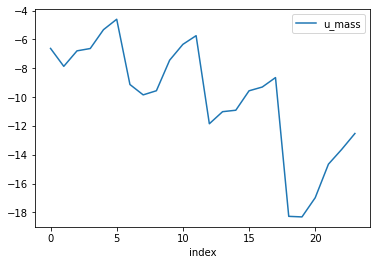

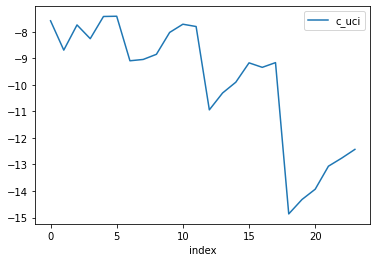

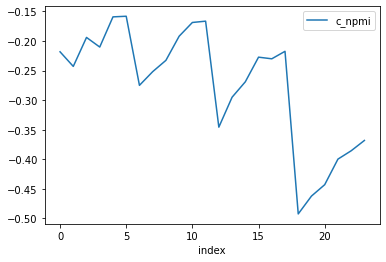

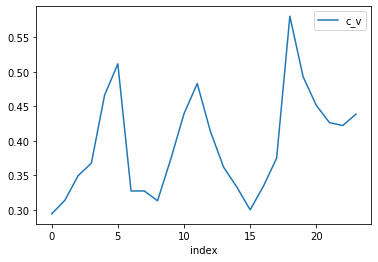

In [ ]:
coherence_df=prepare_coherence_df("Journal of Hydrology",journal_docs)
joh_test_df_u_mass, joh_test_df_u_mass_max=plot(coherence_df,'u_mass')
joh_test_df_c_uci, joh_test_df_c_uci_max=plot(coherence_df,'c_uci')
joh_test_df_c_npmi, joh_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
joh_test_df_c_v, joh_test_df_c_v_max=plot(coherence_df,'c_v')
joh_final_test_df=prepare_final_df(joh_test_df_u_mass_max,joh_test_df_c_uci_max,joh_test_df_c_npmi_max,joh_test_df_c_v_max)
joh_final_test_df

In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Journal of Hydrology/Perc95Topics5/5topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.19835	response prediction spring stream subsurface_displacement recharge som pollution swamp aquifer cluster pore fluctuation baseflow catchment function lwpi mwbms modify simulate 

1	0.24673	drought groundwater velocity formulation salix swc reservoir carbon case swpp_test dam flux couple drift pft rill canopy inundation event rill_flow 

2	0.18144	seepage condition rain cell transport predictor biofilm drainage flood gauge measurement specie solution problem forecast urbanization heat multispecie migration energy 

3	0.19229	concentration confluence change scale resistance mix ca basin landscape year clockwise community subcatchment decomposition property ion load behavior periodicity hysteresis 

4	0.18024	vegetation area connectivity error storm connect soil period groundwater_drought observation inflow program afforestation river live dissolve assumption rock green lake 



## **Annual Review of Environment and Resources**

       Combination Coherence Type  Coherence Value
0    Perc25Topics5         c_npmi        -0.446897
1    Perc25Topics5            c_v         0.493371
2    Perc25Topics5          c_uci       -13.169837
3    Perc25Topics5         u_mass       -13.343658
4   Perc25Topics10         c_npmi        -0.325327
..             ...            ...              ...
91  Perc95Topics25         u_mass       -16.090674
92  Perc95Topics30         c_npmi        -0.465793
93  Perc95Topics30            c_v         0.267779
94  Perc95Topics30          c_uci       -14.403060
95  Perc95Topics30         u_mass       -16.056017

[96 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-9.655129
1,Perc25Topics25,c_uci,-10.823255
2,Perc25Topics25,c_npmi,-0.295724
3,Perc95Topics5,c_v,0.689726


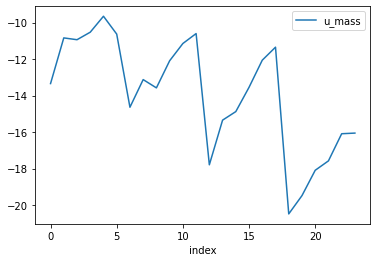

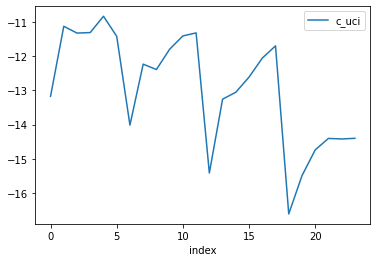

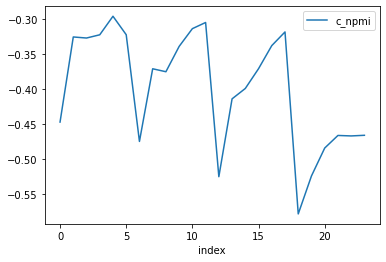

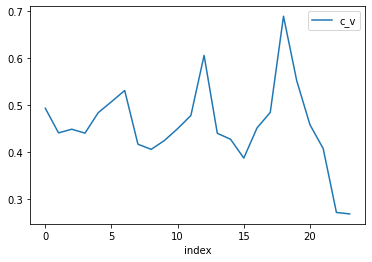

In [ ]:
coherence_df=prepare_coherence_df("Annual Review of Environment and Resources",journal_docs)
arer_test_df_u_mass, arer_test_df_u_mass_max=plot(coherence_df,'u_mass')
arer_test_df_c_uci, arer_test_df_c_uci_max=plot(coherence_df,'c_uci')
arer_test_df_c_npmi, arer_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
arer_test_df_c_v, arer_test_df_c_v_max=plot(coherence_df,'c_v')
arer_final_test_df=prepare_final_df(arer_test_df_u_mass_max,arer_test_df_c_uci_max,arer_test_df_c_npmi_max,arer_test_df_c_v_max)
arer_final_test_df

In [ ]:
arer_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc25Topics25,u_mass,-9.655129
1,Perc25Topics25,c_uci,-10.823255
2,Perc25Topics25,c_npmi,-0.295724
3,Perc95Topics5,c_v,0.689726


In [ ]:
with open(r'/content/drive/MyDrive/Abstract_topic1/Annual Review of Environment and Resources/Perc95Topics5/5topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	3.68532	sanitation governance island insect conflict address surface mining science moisture pathway boundary anthropocene maker biology carbon student audience conservation living 

1	4.41391	soil conservation biodiversity religion source sink remain group methane mammal groundwater resource acidification maker biology introduction growth ste ecotourism food 

2	4.66892	fishery climate consumer innovation difference inequality celebrity limit city decision_making growth st ecotourism regard resource nutrition bushmeat wildlife recognize guide 

3	4.75435	building energy_storage scenario methane carbon sustainability capital storage flux rainfall mineral energy decline interpret entangle foresight life extreme agreement ecotourism 

4	4.32996	corruption diet mangrove water disease environment option country cost part land redd forest climate earth rainfall extreme assessment report tourism 

